<a href="https://colab.research.google.com/github/asokraju/ml-grinding/blob/master/hands_on_ml/Ch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pprint as pp

import os
import urllib
import tarfile
import urllib.request
from zipfile import ZipFile

import scipy
from scipy import stats

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

from sklearn.multiclass import OneVsOneClassifier

from sklearn.neighbors import KNeighborsClassifier

from pandas.plotting import scatter_matrix

np.random.seed(42)
random.seed(42)

# data

In [ ]:
sklearn.__version__

'0.22.2.post1'

In [ ]:
#mnist = fetch_openml('mnist_784', data_home='mnist_dataset/')
#mnist = fetch_openml('mnist_784')
# X = mnist.data
# y = mnist.target
#from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


In [ ]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
print("test : ",len(X_test),"\ntrain : ",len(X_train))

test :  10000 
train :  60000


In [ ]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

# Binary Classification

## SGDClassifier

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

##StratifiedKFold

In [ ]:
skfolds = StratifiedKFold(n_splits=5, random_state=42)
for train_ix, test_ix in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_ix]
    y_train_fold = y_train_5[train_ix]
    X_test_fold = X_train[test_ix]
    y_test_fold = y_train_5[test_ix]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.959
0.9651666666666666
0.9641666666666666
0.9619166666666666
0.9724166666666667


# Confusion matrix
                    Predicted

                    Neg        Pos

            Neg     TN          FP

Actual 

            Pos      FN         TP



Precison = TP/(TP+FP)

Recall = TP/(TP+FN)



Precision: Out of all Positive *prediction* how many are correct (How correct is the classifier).
If the classifier says its correct then it is higly likely its is correct.

Recall: Out of all Positive *truths* how many are correctly classified as truth (detection)

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
confusion_matrix(y_train_5, y_train_pred)


array([[53821,   768],
       [ 1218,  4193]])

In [ ]:
print("precision: ", precision_score(y_train_5, y_train_pred), "\nrecall: ",  recall_score(y_train_5, y_train_pred), "\nF1-score:", f1_score(y_train_5, y_train_pred))

precision:  0.8451925015117919 
recall:  0.7749029754204398 
F1-score: 0.8085229463941381


# precision Recall curve

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

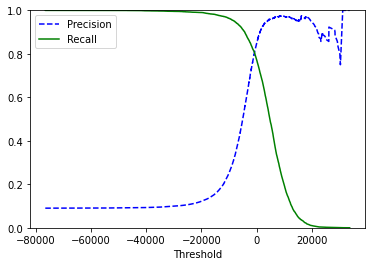

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

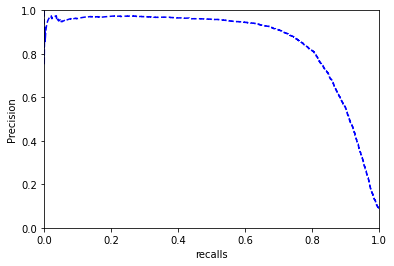

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")
    plt.xlabel("recalls")
    plt.ylabel("Precision")
    #plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


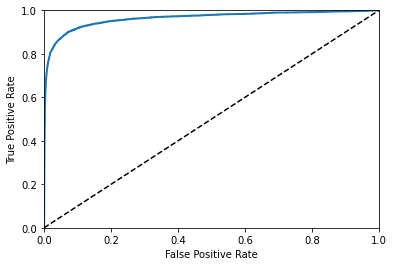

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores)

0.96320230450509

#MUlticlass Classification

one vs the rest Classifier

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_test_pred = sgd_clf.predict(X_test)
sum(y_test_pred==y_test)/len(y_test)

0.8852

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [ ]:
conf_mat = confusion_matrix(y_train, y_train_pred)
print(conf_mat)

[[5724    0   14   10   10   38   53    9   48   11]
 [   1 6415   46   16    9   79   14   15  137   20]
 [  57   38 5095  115   81   70  143  108  250   34]
 [  49   18  194 4642   12  716   29   78  204  179]
 [  21   21   33    4 5182   59   67   39   93  330]
 [ 118   16   30  172   55 4611   97   23  197   92]
 [  60    8   31    3   29  188 5514    8   53    0]
 [  24   14   53   13   54   27    5 5711   44  306]
 [  83   71   55  141   32  537   59   35 4616  221]
 [  44   13   19   41  158  119    3  320  101 5146]]


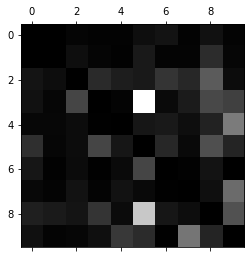

In [ ]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")
#precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:
print( sgd_clf.classes_)
#print(len(sgd_clf.estimators_))

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


##OneVsOneClassifier

In [ ]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [ ]:
print(ovo_clf.classes_)
print(len(ovo_clf.estimators_))

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
45


##RandomForestClassifier

In [ ]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9661, 0.9658, 0.9645])

In [ ]:
forest_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_train_pred_rf = cross_val_predict(forest_clf, X_train, y_train, cv=3)

In [ ]:
conf_mat = confusion_matrix(y_train, y_train_pred_rf)
print(conf_mat)

[[5831    0    9    2    4    7   22    2   36    4]
 [   0 6643   36   17   13    5    7   12   12    7]
 [  23    8 5796   31   26    2   20   38   39    8]
 [   5    8   89 5805    3   62    3   49   66   31]
 [   8    7   10    1 5671    0   29    9   18   96]
 [  20    5    6   67   12 5189   45    3   42   22]
 [  27   12    4    0    9   37 5784    0   21    0]
 [   4   20   77    8   35    1    0 6024   11   71]
 [  11   26   38   50   35   40   26   11 5550   63]
 [  25   11   14   75   65   21    5   58   40 5650]]


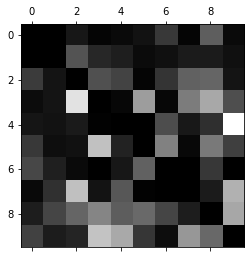

In [ ]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

#Multi Label Classification

In [ ]:
y_train_large = (y_train.astype(int) >= 7)
y_train_odd = (y_train.astype(int) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
cross_val_score(knn_clf, X_train_scaled, y_multilabel, cv=3, scoring="accuracy")

array([0.9599 , 0.95815, 0.9569 ])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9680673218006351

#Multioutput Classification
